# Block 8 Part 2: Network Visualisations

## Networks or Graphs

A network \(G\) consists of a set \(V\) of vertices and a set \(E\) of edges. An edge indicates a relationship between two vertices. Networks provide standard tools for visualisation in data science and related fields. 
Below are some examples of kinds of real world network data that can be represented by networks:
- **Social networks:** Representing people and their social interactions. Examples include
looking into Facebook, LinkedIn, email exchanges, etc.
- **Knowledge networks:** Representing entities and their relationships. For example Google knowledge graph, Bing Satori, Freebase, Yago, Wordnet, etc.
- **Collaboration networks:** Representing people and their collaborations. Examples include Co-authorships from dblp, Google Scholar, Microsoft Academic search, etc.
- **Product purchase networks:** Representing who bought what. Example: Amazon product
purchases
- **Reviews:** Ratings of products or services provided by users. Example: TripAdvisor
- **Medicine:** Disease victor graphs, infection, etc.
- **Road networks, communication networks**.

![Barbasi Book](img/Barbasi.jpg)

![Elections Social Network](img/Elections.png)

![Erdos Numbers](img/figure-1-3.jpg)

![Erdos Collaboration Graph](img/ErdosCollaborationGraph.jpg)

![Erdos Hesham Number](img/Erdos-Hesham.png)

![Erdos Hesham Number](img/Einstein-Hesham.png)

In [1]:
!ls -al img

total 5448
drwxr-xr-x   8 moebqr  staff      256 Jan 26 10:46 .
drwxr-xr-x  13 moebqr  staff      416 Jan 26 10:47 ..
-rw-r--r--   1 moebqr  staff    33074 Jan 26 10:46 Barbasi.jpg
-rw-r--r--   1 moebqr  staff   401951 Jan 26 10:46 Einstein-Hesham.png
-rw-r--r--   1 moebqr  staff  1685961 Jan 26 10:46 Elections.png
-rw-r--r--   1 moebqr  staff   430280 Jan 26 10:46 Erdos-Hesham.png
-rw-r--r--   1 moebqr  staff    79691 Jan 26 10:46 ErdosCollaborationGraph.jpg
-rw-r--r--   1 moebqr  staff   141634 Jan 26 10:46 figure-1-3.jpg


There are several reasons for visualising networks:
- For exploratory data analysis by visual inspection of network drawings
- For visual detection of network structures, e.g. community detection in social networks,
tree or feed-forward structures.
- For communicating network properties

## Networks/Graphs in Python

The standard Python package for the creation, manipulation, and study of the structure of
networks is networkx. 
A tutorial for it can be found here: https://networkx.org/documentation/networkx-1.10/tutorial/index.html

To install networkx type the following
in the terminal or Anaconda prompt:

In [2]:
!pip install networkx

Below are some standard layout styles for networks produced by the networkx package:
- `circular`: Position nodes on a circle
- `random`: Position nodes uniformly at random in the unit square
- `shell`: Position nodes in concentric circles
- `spring`: Position nodes using the Fruchterman-Reingold force-directed algorithm
- `spectral`: position nodes using the eigenvectors of the network Laplacian
  
We will illustrate the above in a **real world dataset**.
In next two subsections, we will explore and pre-process the data and then we will sample from the above styles.

## GitHub Organisations Data

As a working example, we will study the activities of users across different GitHub organizations by a representation of data as a network. 
The vertices of the network will represent organisations and an edge between two vertices will indicate that there is at least one user who initiated an event to at least one repository in each of the two corresponding organizations. 
The edge weights are defined as the number of such users. 
We will use the data retrieved from GitHub archive for 2 March 2015 that are contained in the attached file `2015-03-02.csv`.
We will need to do a fair amount or pre-processing to bring the data in the desired format. 
This can be seen as a good data wrangling exercise. 
First, we initialise Python and load the data.

### Load the needed packages

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load the data

In [6]:
fdate = '2015-03-02'
df = pd.read_csv(fdate + '.csv', parse_dates=['created_at'])
df.head()

,created_at,id,actor.login,org.login,repo.name,type
0,2015-03-02,2615962109,pdgago,simbiotica,simbiotica/charicharts,CreateEvent
1,2015-03-02,2615962111,micmania1,NaN,micmania1/silverstripe-cms,PushEvent
2,2015-03-02,2615962112,xsb,bitpay,bitpay/insight-api,WatchEvent
3,2015-03-02,2615962113,dkorolev,KnowSheet,KnowSheet/Bricks,PullRequestReviewCommentEvent
4,2015-03-02,2615962114,edwin-pers,NaN,edwin-pers/neuromancer,PushEvent


The dataset contains several variables indicating the user (`actor.login`) and the GitHub
organisation (`org.login`) as well as other variables such as date created, ID, name of the
repository and type of event. To check which types of events exist we use the code below:

In [7]:
# find the unique event types
df['type'].unique()

array(['CreateEvent', 'PushEvent', 'WatchEvent',
       'PullRequestReviewCommentEvent', 'IssueCommentEvent',
       'PullRequestEvent', 'DeleteEvent', 'CommitCommentEvent',
       'ForkEvent', 'IssuesEvent', 'GollumEvent', 'MemberEvent',
       'ReleaseEvent', 'PublicEvent'], dtype=object)

### Transform to triplets (actor, organization, repository), remove `WatchEvent` events , drop duplicates and missing values

In [8]:
df = df[(df['type']!='WatchEvent')]
df = df[['actor.login', 'org.login', 'repo.name']]
df = df.drop_duplicates()
df = df[df['org.login'].notnull()]
df.head()

,actor.login,org.login,repo.name
0,pdgago,simbiotica,simbiotica/charicharts
3,dkorolev,KnowSheet,KnowSheet/Bricks
5,dmolsen,pattern-lab,pattern-lab/patternengine-php-twig
7,LordSputnik,BookBrainz,BookBrainz/bookbrainz.org
16,ScottNZ,OpenRA,OpenRA/OpenRA


### Focus on the most frequently observed organisations (top 100)

Next, we want to focus on the most frequently occurring organisations, say the top 100. We will do so using the function `groupby()`.

In [10]:
org_actor_df = df.groupby(['org.login','actor.login']).agg('count').reset_index()
org_actor_df.head()

,org.login,actor.login,repo.name
0,01org,117111302,1
1,01org,MCherifiOSS,1
2,01org,UIKit0,10
3,01org,askervin,1
4,01org,chivakker,1


In [21]:
toporgs = org_actor_df.groupby(['org.login'])['org.login'].agg('count')
toporgs = toporgs.sort_values(ascending=False)[:100].keys().tolist()
toporgs

['mozilla',
 'apache',
 'facebook',
 'google',
 'angular',
 'docker',
 'elasticsearch',
 'iojs',
 'dotnet',
 'owncloud',
 'atom',
 'GoogleCloudPlatform',
 'twbs',
 'rails',
 'rust-lang',
 'github',
 'udacity',
 'puppetlabs',
 'angular-ui',
 'spring-projects',
 'laravel',
 'aspnet',
 'edx',
 'grpc',
 'Homebrew',
 'odoo',
 'thoughtbot',
 'saltstack',
 'jenkinsci',
 'wso2',
 'odoo-dev',
 'twitter',
 'yiisoft',
 'jquery',
 'square',
 'strongloop',
 'mozilla-b2g',
 'driftyco',
 'chef',
 'Microsoft',
 'Azure',
 'w3c',
 'symfony',
 'joomla',
 'ansible',
 'JuliaLang',
 'mapbox',
 'mono',
 'golang',
 'JetBrains',
 'nodeschool',
 'Automattic',
 'NixOS',
 'joyent',
 'rackerlabs',
 'openshift',
 'balderdashy',
 'Polymer',
 'FortAwesome',
 'tgstation',
 'Netflix',
 'cocos2d',
 'alphagov',
 'ministryofjustice',
 'Wikia',
 'ethereum',
 'coreos',
 'xbmc',
 'ceph',
 'cfpb',
 'software-engineering-amsterdam',
 'gitlabhq',
 'WhisperSystems',
 'appium',
 'OCA',
 'mongodb',
 'cms-sw',
 'CyanogenMod',
 'ope

### Create all pairs of organisations present in each user initiated event

The first line in the code above takes all possible pairs of `org.login` and `actor.login` and
applies the operation `.agg('count')` that counts the frequency of each pair. The second line
takes the frequency of each organisation and stores them into toporgs. Finally we sort the
organisations in terms of frequency of appearance and print the top 10 of them.

The next step is almost taking us to our objective as we track the organisations where each user
initiated an event and record all possible pairs between them. For example, if a user accessed
three organisations, we will record the three possible pairs between them using the function
`combinations()` from the Python package `itertools`. Note also that the line for name, group
in `actor_df`: loops over all groups (having their name as well) contained in the `groupby` object
`actor_df` that aggregates over each user.

In [24]:
from itertools import combinations

actor_df = df.groupby('actor.login')
dfs = pd.DataFrame(columns=['Actor', 'Org1', 'Org2'])
for name, group in actor_df:
    orgs = group['org.login'].unique()
    orgs = [val for val in orgs if val in toporgs]
    if len(orgs)>1:
        actor_edge = pd.DataFrame(data=list(combinations(orgs, 2)), columns=['Org1', 'Org2'])
        actor_edge['Actor'] = name
        dfs = pd.concat([dfs, actor_edge])
dfs.head()

,Actor,Org1,Org2
0,1Power,mongodb,rails
0,AntouanK,iojs,npm
0,Carreau,ipython,JuliaLang
0,Dashed,babel,facebook
0,DavidA2014,atom,npm


### Get the weight edges

Each row in the `dfs` data frame corresponds to a user initiating an event to two different
organisations (vertices), in other words it defines an edge to the network. We are almost ready to
proceed; the final steps produce a data frame that allows for a more efficient way to construct the
network by counting the number of times each edge (pair) occurs, also known as weight of the
edge, and records it. We also print the top 10 edges in terms of their weight.

In [25]:
dfs = dfs.groupby(['Org1', 'Org2']).agg('count').reset_index().rename(columns={'Actor': 'weight'})
dfs = dfs.sort_values(by='weight', ascending=False)
dfs.head()

,Org1,Org2,weight
187,odoo-dev,odoo,17
186,odoo,odoo-dev,9
133,iojs,joyent,5
105,google,GoogleCloudPlatform,5
190,openshift,GoogleCloudPlatform,4


## Network Visualisations

### Produce the `Graph` object of the network

Now we proceed to the part of actually producing the network. First we load the `networkx`
package. Graph drawing is a big field and is not straightforward job for a package like this to produce the best layout for the network. We'll try some layouts to see which one works.

In [26]:
import networkx as nx
G = nx.Graph()

for index, row in dfs.iterrows():
    G.add_edge(row['Org1'], row['Org2'], weight=row['weight'])

# remove isolated vertices (if any)    
remove = [node for node,degree in G.degree() if degree ==0]
G.remove_nodes_from(remove)

### Finally produce the plot

Finally, we can now produce a network with the `networkx` package. We start with the spring
style after setting some network options regarding its size and colour:

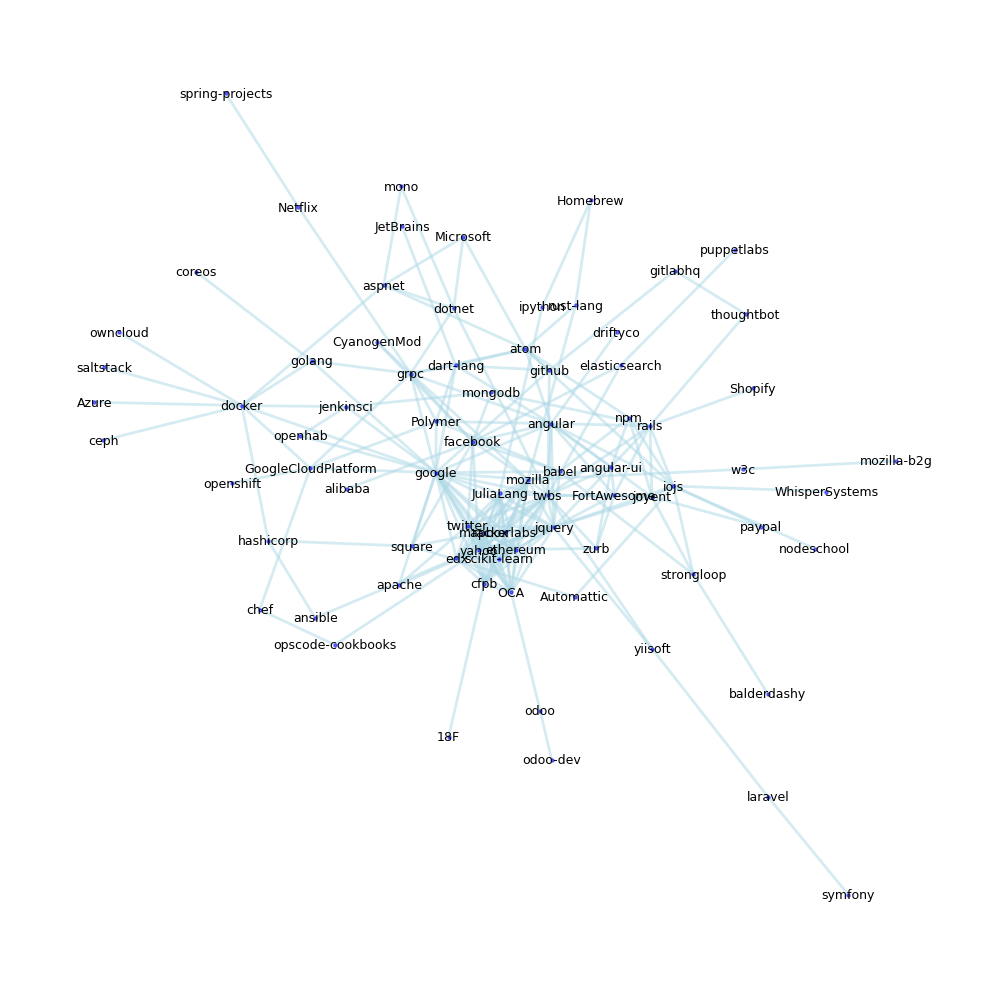

In [32]:
#Setting size and colours
options = {
     'node_color': 'blue',
     'edge_color': 'lightblue',
     'node_size': 5,
     'width': 2,
     'alpha': 0.5,
 }

# Producing the network
plt.subplots(figsize=(10,10))
pos=nx.spring_layout(G)
nx.draw(G,pos=pos,font_size=9,**options)
nx.draw_networkx_labels(G,pos=pos,font_size=9)
plt.tight_layout()
plt.axis('off');

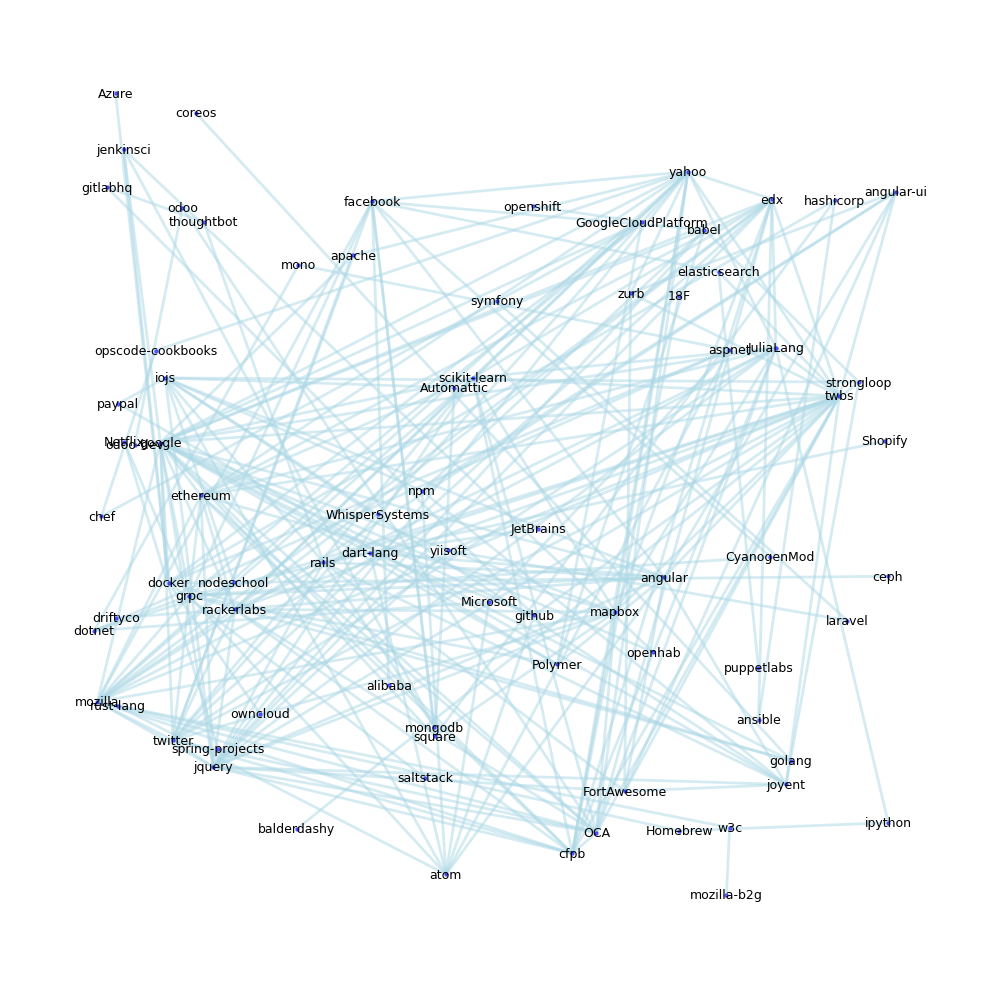

In [33]:
plt.subplots(figsize=(10,10))
pos=nx.random_layout(G)
nx.draw(G,pos=pos,font_size=9,**options)
nx.draw_networkx_labels(G,pos=pos,font_size=9)
plt.tight_layout()
plt.axis('off');
plt.show()

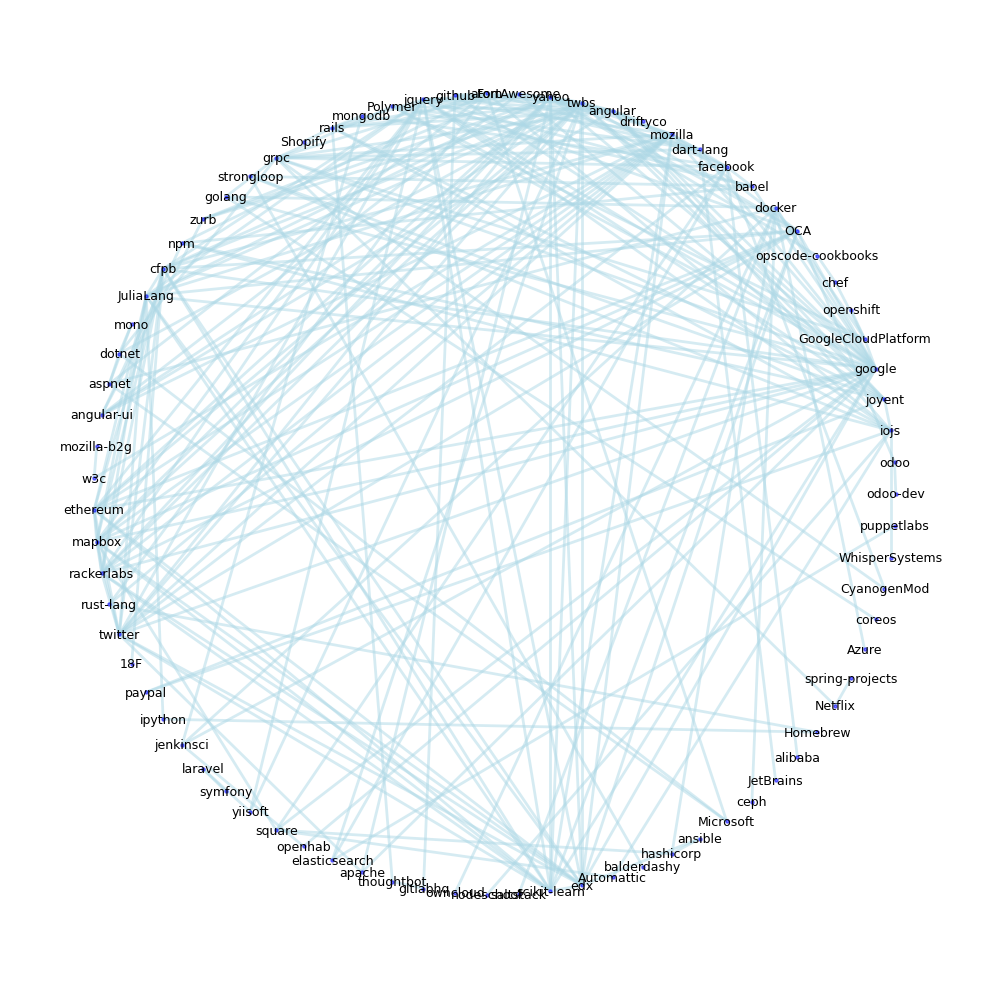

In [34]:
plt.subplots(figsize=(10, 10))
pos = nx.circular_layout(G)
nx.draw(G, pos=pos, font_size=9, **options)
nx.draw_networkx_labels(G, pos=pos, font_size=9)
plt.tight_layout()
plt.axis('off')
plt.show()